# Adjoint plugin

Run this notebook in your browser using [Binder](https://mybinder.org/v2/gh/flexcompute-readthedocs/tidy3d-docs/readthedocs?labpath=docs%2Fsource%2Fnotebooks%2FAdjoint.ipynb).

In [1]:
from typing import List

import numpy as np
import jax.numpy as jnp
import matplotlib.pylab as plt
from jax import grad, value_and_grad

import tidy3d as td
import tidy3d.web as web

from tidy3d.plugins.adjoint.components import JaxSimulation, JaxBox, JaxMedium, JaxStructure, JaxSimulationData
from tidy3d.plugins.adjoint.web import run

INFO:rich:Using client version: 1.8.0


In [2]:
# wavelength and frequency
wavelength = 1.0
freq0 = td.C_0 / wavelength
k0 = 2 * np.pi * freq0 / td.C_0

# resolution control
dl = 0.02

# space between boxes and PML
buffer = 1.5 * wavelength

# initial size of boxes and waveguide
lx0, ly0, lz0 = 1., 1., 8 * dl
wg_width = .7

# position of source and monitor (constant for all)
source_x = -lx0 - 1
meas_x = lx0 + 1

# total size
Lx = 2 * lx0 + 2 * buffer
Ly = 2 * ly0 + 2 * buffer
Lz = lz0 + 2 * buffer

# simulation parameters
boundary_spec = td.BoundarySpec.all_sides(boundary=td.PML())

# permittivity at each quadrant of box
quadrants = [x + y for x in "+-" for y in "+-"]
permittivities = [2.0, 2.5, 3.0, 3.5]

wg_eps = 2.75

# frequency width and run time
freqw = freq0 / 10
run_time = 10 / freqw

# polarization of initial source
pol = "Ey"

# monitor for plotting
monitor_field = td.FieldMonitor(
    center=[0, 0, 0],
    size=[td.inf, td.inf, 0],
    freqs=[freq0],
    name="field_pattern",
)

# default box center and sizes
center = 0 * np.array([-1e-5, -1e-5, -1e-5])

size = np.array([lx0, ly0, lz0])
ds = -0.0

In [3]:
waveguide = td.Structure(
    geometry=td.Box(size=(td.inf, wg_width, lz0)),
    medium=td.Medium(permittivity=wg_eps)
)

mode_size = (0,4,3)

# source seeding the simulation
forward_source = td.ModeSource(
        source_time=td.GaussianPulse(freq0=freq0, fwidth=freq0/10),
        center=[source_x, 0, 0],
        size=mode_size,
        mode_index=0,
        direction="+"
    )

# we'll refer to the measurement monitor by this name often
measurement_monitor_name = 'measurement'

num_modes = 3

# monitor where we compute the objective function from
measurement_monitor = td.ModeMonitor(
    center=[meas_x, 0, 0],
    size=mode_size,
    freqs=[freq0],
    mode_spec=td.ModeSpec(num_modes=num_modes),
    name=measurement_monitor_name,
)

In [4]:
def make_input_structures(*permittivities) -> List[JaxStructure]:

    eps_boxes = {quad: eps for (quad, eps) in zip(quadrants, permittivities)}
    boxes_quad = []
    for i, (quad, eps) in enumerate(eps_boxes.items()):

        x, y = quad
        xsign = 1 if x == "+" else -1
        ysign = 1 if y == "+" else -1

        center_quad = center.tolist()
        center_quad[0] += xsign * lx0 / 2
        center_quad[1] += ysign * ly0 / 2
        size_quad = size.tolist()
        size_quad[0] += i * ds
        size_quad[1] += i * ds

        box_quad = JaxStructure(
            geometry=JaxBox(center=center_quad, size=size_quad),
            medium=JaxMedium(permittivity=eps),
            name=quad,
        )
        boxes_quad.append(box_quad)
    return boxes_quad

In [5]:
def make_sim(*permittivities) -> JaxSimulation:
    """Make a simulation using a sequence of 4 permittivity values."""
    
    input_structures = make_input_structures(*permittivities)
    return JaxSimulation(
        size=[Lx, Ly, Lz],
        grid_spec=td.GridSpec.uniform(dl=dl),
        structures=[waveguide],
        input_structures=input_structures,
        sources=[forward_source],
        monitors=[monitor_field],
        output_monitors=[measurement_monitor],
        run_time=run_time,
        subpixel=False,
        boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
        shutoff=1e-8,
        courant=0.9,
    )

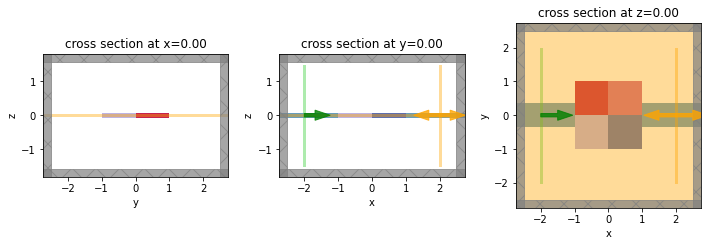

In [6]:
sim_base = make_sim(*permittivities)

f, axes = plt.subplots(1, 3, tight_layout=True, figsize=(10, 5))

for dim, ax in zip('xyz', axes):
    sim_base.to_simulation()[0].plot(**{dim:0}, ax=ax)

plt.show()

In [7]:
def measure_power(sim_data: JaxSimulationData) -> float:
    """Power in the 0th order mode."""
    output_amps = sim_data.output_data[0].amps
    amp = output_amps.sel(direction="+", f=freq0, mode_index=0)
    return jnp.sum(jnp.abs(amp)**2)

In [8]:
def J(*permittivities) -> float:
    """Objective function, construct simulation, run it using adjoint plugin, and return power in mode_index=0."""
    sim = make_sim(*permittivities)
    sim_data = run(sim, task_name="4_boxes")
    power_mode_0 = measure_power(sim_data)
    return power_mode_0

In [9]:
power = J(*permittivities)
print(f"measured power = {power:.2f}")

↓ monitor_data.hdf5 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━ 90.0% • 3.4/3.8 MB • 3.3 MB/s • 0:00:01

INFO:rich:loading SimulationData from simulation_data.hdf5


measured power = 0.44


In [10]:
dJ_fn = grad(J, argnums=(0,1,2,3))

In [11]:
de1, de2, de3, de4 = grad_eps = dJ_fn(*permittivities)

↓ monitor_data.hdf5 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━ 87.0% • 5.0/5.7 MB • 4.6 MB/s • 0:00:01

INFO:rich:loading SimulationData from simulation_data.hdf5


In [12]:
grad_eps = np.array(grad_eps)
grad_grad_eps_normalized = grad_eps / np.linalg.norm(grad_eps)
print(f"Jax gradient: {grad_grad_eps_normalized}")

Jax gradient: [ 0.6001146  -0.3701232   0.40056401 -0.5851665 ]


Numerical Gradient (from Adjoint.ipynb): [0.64185051 -0.28992203  0.37546415 -0.60249465]

In [13]:
grad_jax = np.array(grad_eps).copy() * (dl / k0)**3

# grad_num = np.array([0.23405033, -0.10570175,  0.13699801, -0.2197663])
# [ 0.60110169 -0.37117489  0.40589675 -0.5797877 ]
grad_num = np.array([[ [ 0.60110169, -0.37117489,  0.40589675, -0.5797877 ]]])
rms_error = np.linalg.norm(grad_num - grad_jax) / np.linalg.norm(grad_num)

print('numerical (unnormalized): ', grad_num)
print('using jax (unnormalized): ', grad_jax)
print(f'norm(diff) / norm(numerical): {(rms_error * 100):.3f} %')

numerical (unnormalized):  [[[ 0.60110169 -0.37117489  0.40589675 -0.5797877 ]]]
using jax (unnormalized):  [ 0.19821484 -0.12224985  0.13230428 -0.19327758]
norm(diff) / norm(numerical): 66.972 %


In [14]:
grad_num_normalized = grad_num / np.linalg.norm(grad_num)
grad_jax_normalized = grad_jax / np.linalg.norm(grad_jax)
rms_error_normalized = np.linalg.norm(grad_num_normalized - grad_jax_normalized) / np.linalg.norm(grad_num_normalized)

print('numerical (normalized): ', grad_num_normalized)
print('using jax (normalized): ', grad_jax_normalized)
print(f'norm(diff) / norm(numerical): {(rms_error_normalized * 100):.3f} %')

numerical (normalized):  [[[ 0.60110169 -0.37117489  0.40589675 -0.5797877 ]]]
using jax (normalized):  [ 0.6001145  -0.37012318  0.40056396 -0.5851665 ]
norm(diff) / norm(numerical): 0.771 %


In [15]:
# note, alternatively, you can get the value of J and the gradient in one function (2 simulations as opposed to 3 when called separately)
# dJ_fn_val_grad = value_and_grad(J, argnums=(0,1,2,3))
# J, grad = dJ_fn_val_grad(*permittivities)
# print(J)
# print(grad)